In [1]:
%reload_ext autoreload

# Imports

import os
import sys
module_path = os.path.abspath(os.path.join('../image_gen_dm')) # or the path to your source code
sys.path.append(str(module_path))

import tensorflow as tf
import tf_keras as tfk
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

tfkl = tfk.layers
tfpl = tfp.layers
tfd = tfp.distributions

TF_ENABLE_ONEDNN_OPTS=0
os.environ['TF_ENABLE_ONEDNN_OPTS'] = str(TF_ENABLE_ONEDNN_OPTS)
os.environ['TG_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import image_gen_vae as igvae
import image_gen_vae.constants as consts

print('Tensorflow Version:', tf.__version__)
print("Available GPUs: ", len(tf.config.list_physical_devices('GPU')))

2024-05-05 10:32:50.511186: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow Version: 2.16.1
Available GPUs:  1


2024-05-05 10:33:04.787844: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 10:33:04.849498: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 10:33:04.849590: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# Constants

IMAGE_SIZE = 64
FLATTENED_SIZE = IMAGE_SIZE * IMAGE_SIZE * 3

ENCODER_HIDDEN_SIZES = [8192, 1792, 448]

DECODER_HIDDEN_SIZES = ENCODER_HIDDEN_SIZES[::-1]

LATENT_DIM = 2

MODEL_NAME = 'ncvae'
ENCODER_FILE_PATH = f'res/models/{MODEL_NAME}_encoder.h5'
DECODER_FILE_PATH = f'res/models/{MODEL_NAME}_decoder.h5'

LEARNING_RATE = 1e-4
VAL_PERCENTAGE = 0.1

In [ ]:
# Dataset loading

train_ds, val_ds = igvae.utils.load_datasets(val_percentage=VAL_PERCENTAGE)

In [3]:
# Model class

# This code is heavily based on the Keras Team's example on Convolutional VAEs with only minor modifications.
# The original code can be found at: https://github.com/keras-team/keras-io/blob/master/examples/generative/vae.py

# Author: [fchollet](https://twitter.com/fchollet)
# Licensed under the Apache License 2.0. See LICENSE file in the root directory for more information.


class Sampling(tfkl.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class NCVAE(tfk.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tfk.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            input_data, target_data = data
            z_mean, z_log_var, z = self.encoder(input_data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.losses.binary_crossentropy(target_data, reconstruction), 
                    axis=(1,2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, input_data, training=False):
        _, _, z = self.encoder(input_data)
        reconstructed_image = self.decoder(z)

        return reconstructed_image


In [4]:
# Encoder

image_input = tfkl.Input(shape=consts.INPUT_SHAPE, name='image_input')

flattened_image = tfkl.Flatten()(image_input)

x = flattened_image
for layer_size in ENCODER_HIDDEN_SIZES:
    x = tfkl.Dense(layer_size, 
            activation='relu',
            kernel_initializer='glorot_uniform')(x)
    
z_mean = tfkl.Dense(LATENT_DIM, name='z_mean', kernel_initializer='glorot_uniform')(x)
z_log_var = tfkl.Dense(LATENT_DIM, name='z_log_var', kernel_initializer='glorot_uniform')(x)

z = Sampling()([z_mean, z_log_var])

encoder = tfk.Model(inputs=image_input, outputs=[z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Decoder

latent_inputs = tfkl.Input(shape=(LATENT_DIM,))

y = latent_inputs
for layer_size in DECODER_HIDDEN_SIZES:
    y = tfkl.Dense(layer_size, 
            activation='relu',
            kernel_initializer='glorot_uniform')(y)
    
reconstructed_flattened_image = tfkl.Dense(FLATTENED_SIZE, kernel_initializer='glorot_uniform', activation='sigmoid')(y)
reshaped_image = tfkl.Reshape(consts.OUTPUT_SHAPE)(reconstructed_flattened_image)

decoder = tfk.Model(inputs=latent_inputs, outputs=reshaped_image, name='decoder')
decoder.summary()

# Model
        
model = NCVAE(encoder, decoder)
model.compile(optimizer=tfk.optimizers.Adam(learning_rate=LEARNING_RATE))


2024-05-05 10:34:16.016891: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 10:34:16.017178: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 10:34:16.017277: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 10:34:18.160772: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 10:34:18.160882: I external/local_xla/xla/stream_executor

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 flatten (Flatten)           (None, 12288)                0         ['image_input[0][0]']         
                                                                                                  
 dense (Dense)               (None, 8192)                 1006714   ['flatten[0][0]']             
                                                          88                                      
                                                                                                  
 dense_1 (Dense)             (None, 1792)                 1468185   ['dense[0][0]']         

In [5]:
# Load weights

if os.path.exists(ENCODER_FILE_PATH) and os.path.exists(DECODER_FILE_PATH):
    encoder.load_weights(ENCODER_FILE_PATH)
    decoder.load_weights(DECODER_FILE_PATH)

else:
    print('No weights found')

In [ ]:
# Run model

epochs = 4096

history = igvae.run_model(model=model, train_ds=train_ds, val_ds=val_ds, epochs=epochs, name=MODEL_NAME, plot=False, time=True)

file_path = f'res/histories/{MODEL_NAME}.csv'

history_df = pd.DataFrame(history.history)

if os.path.exists(file_path):
    df = pd.read_csv(file_path)

    last_time = df['elapsed_time'].iloc[-1]
    history_df['elapsed_time'] += last_time

    history_df.to_csv(file_path, mode='a', header=False, index=False)
else:
    history_df.to_csv(file_path, mode='w', header=True, index=False)

encoder.save_weights(ENCODER_FILE_PATH)
decoder.save_weights(DECODER_FILE_PATH)


In [ ]:
# Save model weights

encoder.save_weights(ENCODER_FILE_PATH)
decoder.save_weights(DECODER_FILE_PATH)

In [ ]:
# Load csv file

csv_file = f'res/histories/{MODEL_NAME}.csv'
df = pd.read_csv(csv_file)

In [ ]:
# Calculate mean loss

df['loss_avg'] = df['loss'].rolling(window=256).mean()

print(df['loss_avg'])


In [ ]:
# Plot loss

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.ylim(2555, 2590)

plt.plot(df['loss'], label='cae', color='blue')
plt.legend(loc="upper left")

plt.show()

In [ ]:
# Plot elapsed time

plt.ylabel('Elapsed Time')
plt.xlabel('Epoch')

plt.plot(df['elapsed_time'], label='cae', color='blue')

plt.legend(loc="upper left")

plt.show()

In [ ]:
# Validate model

igvae.val_model(model=model)

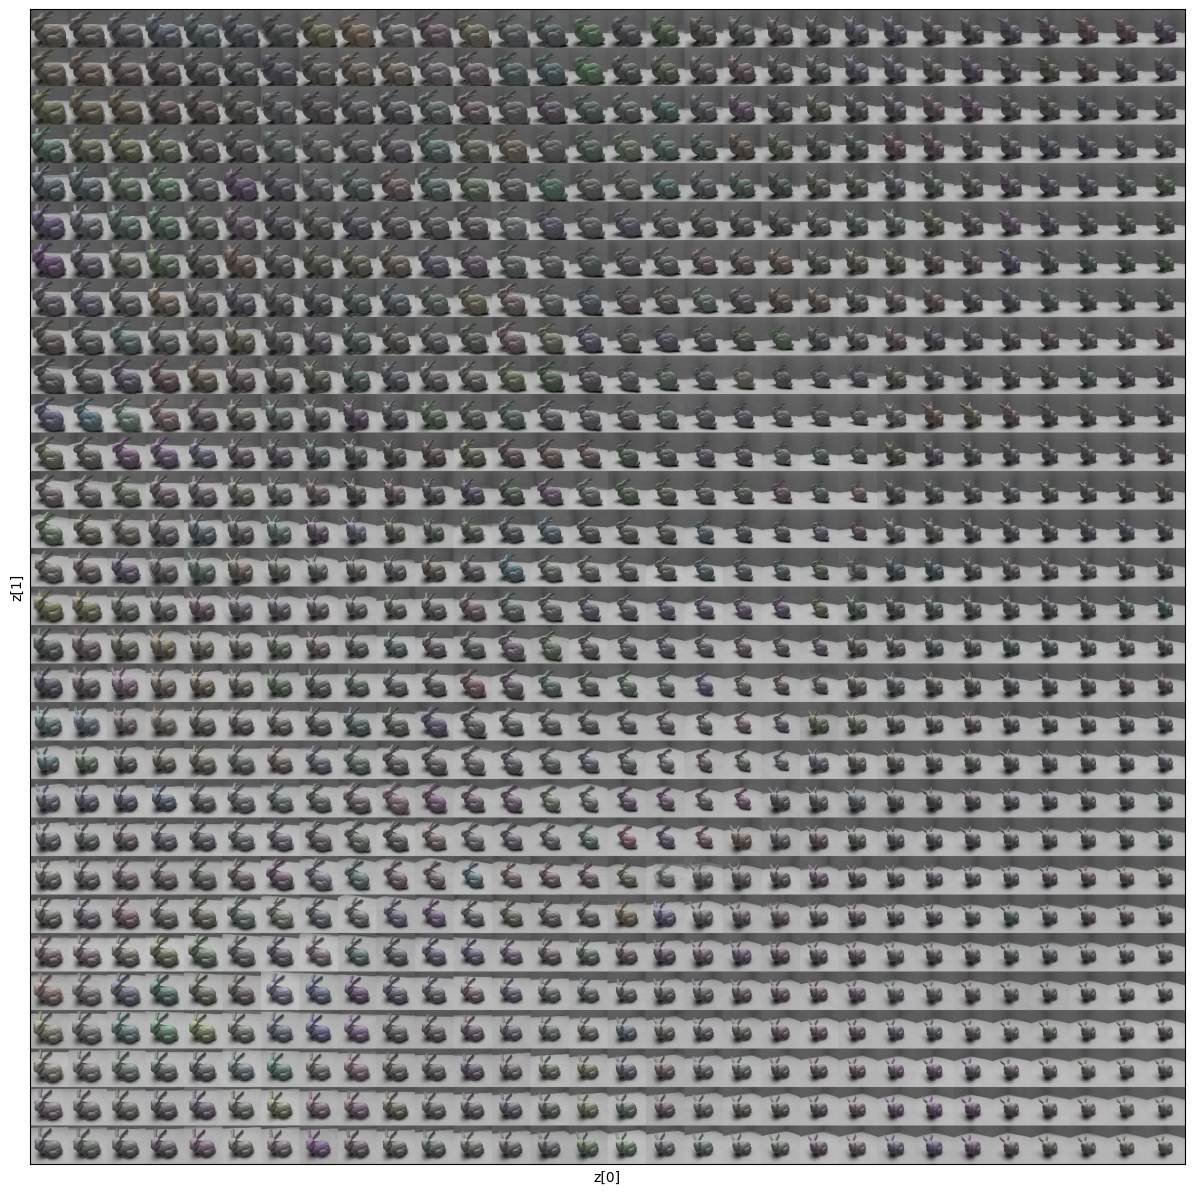

In [19]:
# Plot latent space

igvae.plot_latent_space(model=model, start=-1.5, stop=1.5)

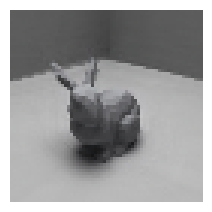

In [6]:
# Generate single image

_ = igvae.gen_image(model=model)

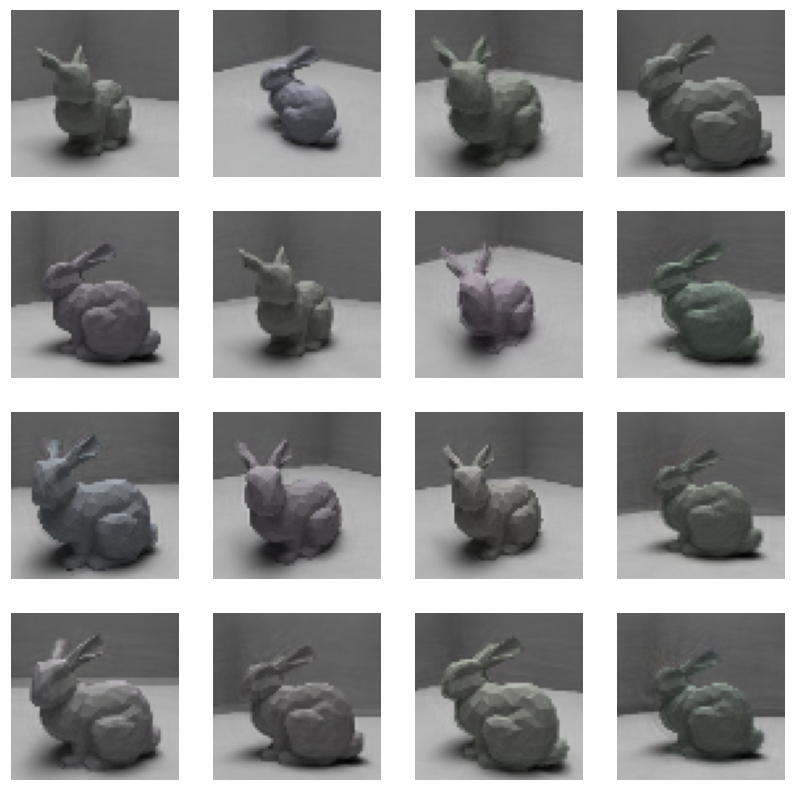

In [27]:
# Generate multiple images

igvae.gen_images(model=model, count=16, min=-1.5, max=1.5)

In [28]:
# Generate all images

num_images = 18000

for j in range(num_images):
    image = igvae.gen_image(model=model, plot=False, min=-1.5, max=1.5)

    # Print progress
    if j % 100 == 0:
        print(f'{j}/{num_images}')

    # Save tensorflow image to res/fcae_images
    image_path = f'res/ncvae_images/ncvae_image{j}.png'
    tfk.preprocessing.image.save_img(image_path, image)

0/18000
100/18000
200/18000
300/18000
400/18000
500/18000
600/18000
700/18000
800/18000
900/18000
1000/18000
1100/18000
1200/18000
1300/18000
1400/18000
1500/18000
1600/18000
1700/18000
1800/18000
1900/18000
2000/18000
2100/18000
2200/18000
2300/18000
2400/18000
2500/18000
2600/18000
2700/18000
2800/18000
2900/18000
3000/18000
3100/18000
3200/18000
3300/18000
3400/18000
3500/18000
3600/18000
3700/18000
3800/18000
3900/18000
4000/18000
4100/18000
4200/18000
4300/18000
4400/18000
4500/18000
4600/18000
4700/18000
4800/18000
4900/18000
5000/18000
5100/18000
5200/18000
5300/18000
5400/18000
5500/18000
5600/18000
5700/18000
5800/18000
5900/18000
6000/18000
6100/18000
6200/18000
6300/18000
6400/18000
6500/18000
6600/18000
6700/18000
6800/18000
6900/18000
7000/18000
7100/18000
7200/18000
7300/18000
7400/18000
7500/18000
7600/18000
7700/18000
7800/18000
7900/18000
8000/18000
8100/18000
8200/18000
8300/18000
8400/18000
8500/18000
8600/18000
8700/18000
8800/18000
8900/18000
9000/18000
9100/18000
